# Used BMW prediction

Sulthan Abiyyu | 24 January 2022

In [26]:
import pandas as pd

In [27]:
bmw = pd.read_csv("./data/bmw.csv")
bmw.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


### Preprocessing

In [28]:
bmw.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [29]:
bmw["model"].nunique(), bmw["transmission"].nunique(), bmw["fuelType"].nunique()

(24, 3, 5)

In [30]:
cat_col = ["model", "transmission", "fuelType"]

df = pd.get_dummies(bmw, columns=cat_col)
df.head()


,year,price,mileage,tax,mpg,engineSize,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,...,model_ i3,model_ i8,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2014,11200,67068,125,57.6,2.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,2018,27000,14827,145,42.8,2.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,2016,16000,62794,160,51.4,3.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,2017,12750,26676,145,72.4,1.5,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,2014,14500,39554,160,50.4,3.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    10781 non-null  int64  
 1   price                   10781 non-null  int64  
 2   mileage                 10781 non-null  int64  
 3   tax                     10781 non-null  int64  
 4   mpg                     10781 non-null  float64
 5   engineSize              10781 non-null  float64
 6   model_ 1 Series         10781 non-null  uint8  
 7   model_ 2 Series         10781 non-null  uint8  
 8   model_ 3 Series         10781 non-null  uint8  
 9   model_ 4 Series         10781 non-null  uint8  
 10  model_ 5 Series         10781 non-null  uint8  
 11  model_ 6 Series         10781 non-null  uint8  
 12  model_ 7 Series         10781 non-null  uint8  
 13  model_ 8 Series         10781 non-null  uint8  
 14  model_ M2               10781 non-null

In [32]:
int_col = ["mileage", "tax", "mpg", "engineSize"]

In [33]:
# standard scaler
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
df[int_col] = s.fit_transform(df[int_col])

In [36]:
df["year"].astype("category")

0        2014
1        2018
2        2016
3        2017
4        2014
         ... 
10776    2016
10777    2016
10778    2017
10779    2014
10780    2017
Name: year, Length: 10781, dtype: category
Categories (25, int64): [1996, 1997, 1998, 1999, ..., 2017, 2018, 2019, 2020]

In [37]:
X = df.drop(["price"], axis=1)
y = df["price"]

X.shape, y.shape

((10781, 37), (10781,))

In [42]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling

In [56]:
# elastic net
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

en = ElasticNet(alpha=0.01, l1_ratio=1)
en.fit(X_train, y_train)
y_pred = en.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred)) # it is off by $4200

D:\Anaconda\envs\DataScience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.356e+10, tolerance: 1.126e+08
  model = cd_fast.enet_coordinate_descent(


4257.819933605558

In [125]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(Dense(units=100, activation="relu", input_dim=X.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=200, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(units=1))

In [126]:
rmse = RootMeanSquaredError()

model.compile(loss="mse", optimizer="adam", metrics=[rmse])

In [127]:
import datetime
import os


logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=[X_test,y_test], callbacks=[tensorboard_callback])

Epoch 1/100
270/270 [==============================] - 1s 2ms/step - loss: 208545152.0000 - root_mean_squared_error: 14441.0928 - val_loss: 129598440.0000 - val_root_mean_squared_error: 11384.1309
Epoch 2/100
270/270 [==============================] - 0s 2ms/step - loss: 135042336.0000 - root_mean_squared_error: 11620.7715 - val_loss: 127742608.0000 - val_root_mean_squared_error: 11302.3271
Epoch 3/100
270/270 [==============================] - 0s 2ms/step - loss: 135948288.0000 - root_mean_squared_error: 11659.6865 - val_loss: 126495336.0000 - val_root_mean_squared_error: 11247.0146
Epoch 4/100
270/270 [==============================] - 0s 2ms/step - loss: 133569832.0000 - root_mean_squared_error: 11557.2412 - val_loss: 125752880.0000 - val_root_mean_squared_error: 11213.9590
Epoch 5/100
270/270 [==============================] - 0s 2ms/step - loss: 133606872.0000 - root_mean_squared_error: 11558.8438 - val_loss: 126227416.0000 - val_root_mean_squared_error: 11235.0977
Epoch 6/100
270

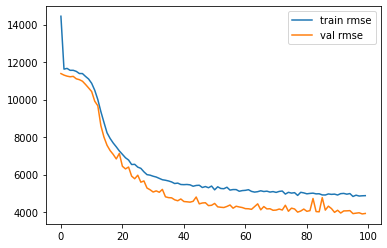

In [128]:
# plot history
import matplotlib.pyplot as plt

rmse = history.history["root_mean_squared_error"]
val_rmse = history.history["val_root_mean_squared_error"]

plt.plot(rmse, label="train rmse")
plt.plot(val_rmse, label="val rmse")
plt.legend()
plt.show()

In [129]:
y_pred_nn = model.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred_nn))  # it is off by $3925


3925.5504345176873

I won't use nn, I'll try to maximize machine learning model's performance

### Hypertuning

In [130]:
import optuna

def objective(trial):
    l1_ratio = trial.suggest_uniform("l1_ratio", 0, 1)
    alpha = trial.suggest_loguniform("alpha", 1e-5, 1e-1)
    en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    en.fit(X_train, y_train)
    y_pred = en.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [135]:
import warnings 
warnings.filterwarnings("ignore")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2022-01-24 11:32:20,074] A new study created in memory with name: no-name-750ffe28-0421-4a65-9f76-ea79d0e38582
[I 2022-01-24 11:32:20,151] Trial 0 finished with value: 4508.595738729315 and parameters: {'l1_ratio': 0.8069655854326531, 'alpha': 0.015526160515988095}. Best is trial 0 with value: 4508.595738729315.
[I 2022-01-24 11:32:20,405] Trial 1 finished with value: 4286.670636975919 and parameters: {'l1_ratio': 0.49892076939137, 'alpha': 0.0007691354332266549}. Best is trial 1 with value: 4286.670636975919.
[I 2022-01-24 11:32:20,424] Trial 2 finished with value: 5580.141437793321 and parameters: {'l1_ratio': 0.2408779478613724, 'alpha': 0.047845362353452325}. Best is trial 1 with value: 4286.670636975919.
[I 2022-01-24 11:32:20,616] Trial 3 finished with value: 4259.108147873871 and parameters: {'l1_ratio': 0.7671912642827224, 'alpha': 9.511989653843921e-05}. Best is trial 3 with value: 4259.108147873871.
[I 2022-01-24 11:32:20,713] Trial 4 finished with value: 4440.728710090381

In [136]:
from sklearn.svm import SVR

svr = SVR(kernel="rbf", C=1e3, gamma=0.1)
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_svr))

4080.8689368713585

In [137]:
def objective_svr(trial):
    C = trial.suggest_loguniform("C", 1e-5, 1e5)
    gamma = trial.suggest_loguniform("gamma", 1e-5, 1e5)
    svr = SVR(kernel="rbf", C=C, gamma=gamma)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [138]:
study_svr = optuna.create_study(direction="minimize")
study_svr.optimize(objective_svr, n_trials=100)

[I 2022-01-24 11:33:54,421] A new study created in memory with name: no-name-36627ff2-9588-47e1-8312-f9c0f8c07ee8
[I 2022-01-24 11:33:59,664] Trial 0 finished with value: 11707.44375105808 and parameters: {'C': 0.009746930281799725, 'gamma': 2.592109693404751e-05}. Best is trial 0 with value: 11707.44375105808.
[I 2022-01-24 11:34:05,497] Trial 1 finished with value: 11707.450232440126 and parameters: {'C': 0.000437779915872557, 'gamma': 16.063460477487325}. Best is trial 0 with value: 11707.44375105808.
[I 2022-01-24 11:34:12,951] Trial 2 finished with value: 10745.292506679963 and parameters: {'C': 928.0740752034972, 'gamma': 390.9924205236257}. Best is trial 2 with value: 10745.292506679963.
[I 2022-01-24 11:34:20,351] Trial 3 finished with value: 11477.47426324514 and parameters: {'C': 1134.8278423826737, 'gamma': 49900.90629306214}. Best is trial 2 with value: 10745.292506679963.
[I 2022-01-24 11:34:52,923] Trial 4 finished with value: 4329.840441773333 and parameters: {'C': 53750

In [148]:
final_svr = SVR(kernel="rbf", C=study_svr.best_params["C"], gamma=study_svr.best_params["gamma"])
final_svr.fit(X_train, y_train)
y_pred_final_svr = final_svr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_final_svr))

2914.548666981176

In [154]:
# cross validation
from sklearn.model_selection import cross_val_score

cv = cross_val_score(final_svr, X, y, cv=5, scoring="neg_mean_squared_error")

In [182]:
print("fold 1 : ", np.sqrt(-cv[0]))
print("fold 2 : ", np.sqrt(-cv[1]))
print("fold 3 : ", np.sqrt(-cv[2]))
print("fold 4 : ", np.sqrt(-cv[3]))
print("fold 5 : ", np.sqrt(-cv[4]))

print("mean fold : ",np.sqrt(-np.mean(cv))) # off by $2914


fold 1 :  2237.182211530244
fold 2 :  3789.8020882059163
fold 3 :  3292.0641998295246
fold 4 :  2534.2802365523157
fold 5 :  2417.5095769815457
mean fold :  2914.522248442569


In [173]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_xgbr))

2760.386544921518

In [174]:
def objective_xgbr(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    xgbr = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
    xgbr.fit(X_train, y_train)
    y_pred = xgbr.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [175]:
study_xgbr = optuna.create_study(direction="minimize")
study_xgbr.optimize(objective_xgbr, n_trials=100)

[I 2022-01-24 12:05:51,742] A new study created in memory with name: no-name-3a36b5c7-8fb5-4be9-97a8-8782f3d931af
[I 2022-01-24 12:05:52,853] Trial 0 finished with value: 22765.984998864587 and parameters: {'n_estimators': 305, 'learning_rate': 0.0004045813297994929}. Best is trial 0 with value: 22765.984998864587.
[I 2022-01-24 12:05:53,799] Trial 1 finished with value: 3990.219321453666 and parameters: {'n_estimators': 288, 'learning_rate': 0.008327778896234516}. Best is trial 1 with value: 3990.219321453666.
[I 2022-01-24 12:05:54,525] Trial 2 finished with value: 25581.482524927884 and parameters: {'n_estimators': 216, 'learning_rate': 1.2467826859933095e-05}. Best is trial 1 with value: 3990.219321453666.
[I 2022-01-24 12:05:55,876] Trial 3 finished with value: 2710.5438160886088 and parameters: {'n_estimators': 421, 'learning_rate': 0.05943527611709936}. Best is trial 3 with value: 2710.5438160886088.
[I 2022-01-24 12:05:57,219] Trial 4 finished with value: 24909.748931180282 and

In [179]:
final_xgbr = XGBRegressor(**study_xgbr.best_params)
final_xgbr.fit(X_train, y_train)
y_pred_final_xgbr = final_xgbr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_final_xgbr))

2626.0393726694474

In [180]:
cv_xgbr = cross_val_score(final_xgbr, X, y, cv=5, scoring="neg_mean_squared_error")

In [185]:
print(f"""
fold 1 : {np.sqrt(-cv_xgbr[0])}
fold 2 : {np.sqrt(-cv_xgbr[1])}
fold 3 : {np.sqrt(-cv_xgbr[2])}
fold 4 : {np.sqrt(-cv_xgbr[3])}  
fold 5 : {np.sqrt(-cv_xgbr[4])}

mean fold : {np.sqrt(-np.mean(cv_xgbr))}
    """) # off by $2682


fold 1 : 2100.499858468726
fold 2 : 3556.1235701176647
fold 3 : 3026.9049061476167
fold 4 : 2435.0341748376813  
fold 5 : 1954.9523080311772

mean fold : 2682.219147330729
    
